# Jogeset Hálózat Elemzése
Ebben a notebookban a `graph_builder.py` szkript által létrehozott jogeset hálózatot elemezzük.

In [1]:
# ===== 1. Szükséges könyvtárak importálása =====

# Standard és külső könyvtárak
import os
import sys
import json
import pickle
import io
import logging
import time
from collections import Counter, defaultdict
from dotenv import load_dotenv

# Adattudományi és vizualizációs könyvtárak
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from community import community_louvain
from azure.storage.blob import BlobServiceClient

# ===== 2. Alapbeállítások =====

# Figyelmeztetések kikapcsolása
import warnings
warnings.filterwarnings('ignore')

# Loggolás alapbeállítása
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("azure.core.pipeline.policies.http_logging_policy").setLevel(logging.WARNING)

# Projekt gyökérkönyvtár hozzáadása a path-hoz
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# .env fájl betöltése az AZURE_CONNECTION_STRING-hez
dotenv_path = os.path.join(project_root, '.env')
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)
    print(".env fájl betöltve.")
else:
    print("Figyelem: .env fájl nem található a projekt gyökerében. Az AZURE_CONNECTION_STRING környezeti változónak be kell lennie állítva.")

# Matplotlib stílus beállítása
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

print("\nBeállítások és importok sikeresen betöltve.")

.env fájl betöltve.

Beállítások és importok sikeresen betöltve.


In [2]:
# ===== 3. Konfiguráció és Azure segédosztály =====

# Konfiguráció importálása
try:
    from configs import config
    AZURE_CONTAINER_NAME = config.AZURE_CONTAINER_NAME
    GRAPH_BLOB_PATH = config.BLOB_GRAPH
    print('Config fájl sikeresen betöltve.')
    print(f"Container: {AZURE_CONTAINER_NAME}, Graph Path: {GRAPH_BLOB_PATH}")
except (ImportError, AttributeError) as e:
    print(f'Hiba a config fájl betöltésekor: {e}. Alapértelmezett értékek használata.')
    AZURE_CONTAINER_NAME = "courtrankrl"
    GRAPH_BLOB_PATH = "graph/document_graph.gpickle"

# Azure Blob Storage segédosztály
class AzureBlobStorage:
    def __init__(self, container_name: str):
        self.connection_string = os.getenv("AZURE_CONNECTION_STRING")
        if not self.connection_string:
            raise ValueError("AZURE_CONNECTION_STRING környezeti változó nincs beállítva.")
        self.container_name = container_name
        self.blob_service_client = BlobServiceClient.from_connection_string(self.connection_string)

    def download_data(self, blob_path: str) -> bytes:
        """Letölt egy fájlt az Azure Blob Storage-ból byte-ként."""
        print(f"Adatok letöltése innen: {self.container_name}/{blob_path}...")
        blob_client = self.blob_service_client.get_blob_client(container=self.container_name, blob=blob_path)
        data = blob_client.download_blob().readall()
        print("Letöltés sikeres.")
        return data

# ===== 4. Gráf betöltése =====

G = None
try:
    storage_client = AzureBlobStorage(container_name=AZURE_CONTAINER_NAME)
    graph_data_bytes = storage_client.download_data(GRAPH_BLOB_PATH)
    
    # A letöltött byte-okból betöltjük a gráfot a pickle segítségével
    G = pickle.load(io.BytesIO(graph_data_bytes))
    
    print("\nGráf sikeresen betöltve a Blob Storage-ból.")
    
    # Metaadatok kiolvasása a gráfból
    print("\n--- Beágyazott Metaadatok ---")
    if G.graph:
        for key, value in G.graph.items():
            if isinstance(value, list) and len(value) > 20:
                 print(f"- {key}: (lista, {len(value)} elemmel)")
            else:
                 print(f"- {key}: {value}")
    else:
        print("Nincsenek beágyazott metaadatok a gráfban.")

except Exception as e:
    print(f"HIBA a gráf letöltése vagy betöltése során: {e}")

Config fájl sikeresen betöltve.
Container: courtrankrl, Graph Path: graph/document_graph.gpickle
Adatok letöltése innen: courtrankrl/graph/document_graph.gpickle...
Letöltés sikeres.

Gráf sikeresen betöltve a Blob Storage-ból.

--- Beágyazott Metaadatok ---
- creation_timestamp_utc: 2025-07-14T16:37:19.823933+00:00
- document_count: 389613
- stop_jogszabalyok_count: 393


## Alapvető Gráf Jellemzők

Kiírjuk a gráf alapvető jellemzőit, mint a csomópontok és élek száma, az átlagos fokszám és a sűrűség.

In [3]:
if G:
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    print(f'Csomópontok száma: {num_nodes}')
    print(f'Élek száma: {num_edges}')
    
    if num_nodes > 0:
        # Fokszámok kiszámítása (mivel irányított gráf)
        avg_in_degree = sum(d for n, d in G.in_degree()) / num_nodes
        avg_out_degree = sum(d for n, d in G.out_degree()) / num_nodes
        
        print(f'Átlagos bejövő fokszám: {avg_in_degree:.2f}')
        print(f'Átlagos kimenő fokszám: {avg_out_degree:.2f}')
        
        # Gráf sűrűsége
        density = nx.density(G)
        print(f'Gráf sűrűsége: {density:.8f}')
    else:
        print('A gráf üres.')
else:
    print('A gráf (G) nincs betöltve. Futtasd az előző cellákat!')

Csomópontok száma: 1600901
Élek száma: 4290100
Átlagos bejövő fokszám: 2.68
Átlagos kimenő fokszám: 2.68
Gráf sűrűsége: 0.00000167


## Csomópont Típusok Elemzése

Megszámoljuk a különböző típusú csomópontokat (pl. `dokumentum`, `bíróság`, `jogszabály`) és vizualizáljuk az eloszlásukat.

In [4]:
if G:
    node_types = nx.get_node_attributes(G, 'type')
    type_counts = pd.Series(node_types).value_counts()
    
    print('--- Csomópont típusok eloszlása ---')
    print(type_counts)
    
    # Plotly oszlopdiagram
    fig = px.bar(
        type_counts, 
        x=type_counts.index, 
        y=type_counts.values, 
        labels={'x':'Típus', 'y':'Darabszám'},
        title='Csomópont Típusok Eloszlása',
        text_auto=True
    )
    fig.update_layout(xaxis_title="Csomópont Típus", yaxis_title="Darabszám")
    fig.show()
else:
    print('A gráf (G) nincs betöltve.')

--- Csomópont típusok eloszlása ---
jogszabaly    1211125
dokumentum     389613
birosag           163
Name: count, dtype: int64


## Fokszám Eloszlás Vizualizációja

Megvizsgáljuk a bejövő, kimenő és teljes fokszámok eloszlását, hogy azonosítsuk a legfontosabb csomópontokat. A logaritmikus skála segít a "long-tail" eloszlások jobb láthatóságában.

--- Legmagasabb bejövő fokszámú csomópontok ---


,Csomópont,Bejövő Fokszám
3,birosag_kúria,52554
1378,null,39069
4250,birosag_fővárosi_törvényszék,38257
636,birosag_fővárosi_ítélőtábla,32744
8504,birosag_budapest_környéki_törvényszék,8844



--- Legmagasabb kimenő fokszámú csomópontok ---


,Csomópont,Kimenő Fokszám
1163708,Mfv.10540/2018/7,3640
964343,Pf.20688/2021/6,2740
1513040,Pf.20320/2017/6,1880
6106,K.27366/2017/8,680
229276,K.27028/2018/3,667


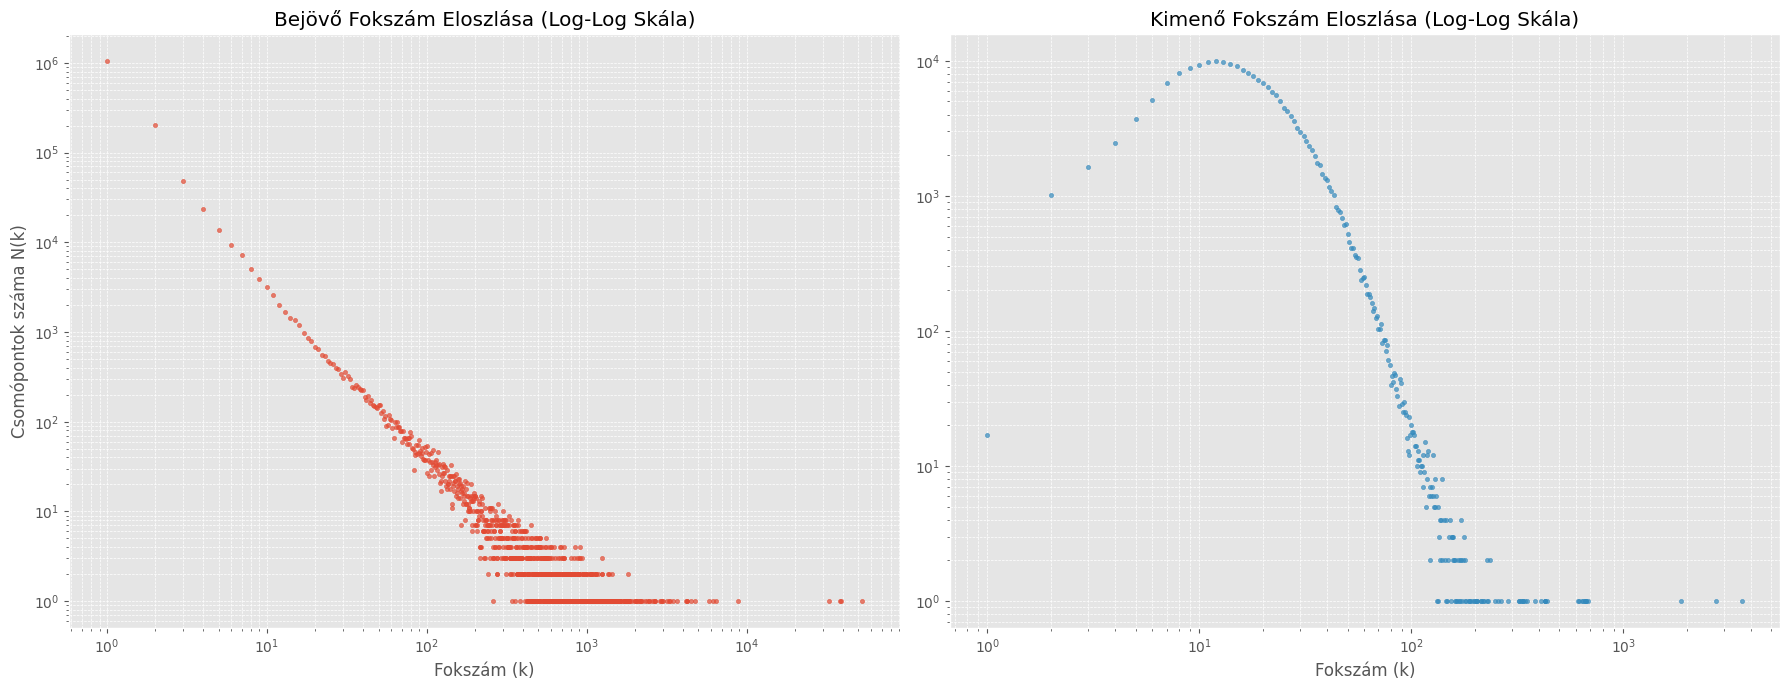

In [11]:
if G and G.number_of_nodes() > 0:
    # Fokszámok kinyerése és a nullák kiszűrése (log skála miatt)
    in_degrees = [d for n, d in G.in_degree() if d > 0]
    out_degrees = [d for n, d in G.out_degree() if d > 0]
    
    # Fokszám-gyakoriságok számolása
    in_degree_counts = pd.Series(in_degrees).value_counts().sort_index()
    out_degree_counts = pd.Series(out_degrees).value_counts().sort_index()
    
    # A top csomópontok listázása továbbra is hasznos
    in_degree_df = pd.DataFrame(G.in_degree(), columns=['Csomópont', 'Bejövő Fokszám']).sort_values('Bejövő Fokszám', ascending=False)
    out_degree_df = pd.DataFrame(G.out_degree(), columns=['Csomópont', 'Kimenő Fokszám']).sort_values('Kimenő Fokszám', ascending=False)
    
    print('--- Legmagasabb bejövő fokszámú csomópontok ---')
    display(in_degree_df.head())
    
    print('\n--- Legmagasabb kimenő fokszámú csomópontok ---')
    display(out_degree_df.head())
    
    # Javított ábrázolás pontdiagrammal, log-log skálán
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Bejövő fokszám
    axes[0].scatter(in_degree_counts.index, in_degree_counts.values, marker='.', alpha=0.7, color='C0')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_title('Bejövő Fokszám Eloszlása (Log-Log Skála)')
    axes[0].set_xlabel('Fokszám (k)')
    axes[0].set_ylabel('Csomópontok száma N(k)')
    axes[0].grid(True, which="both", ls="--", linewidth=0.5)

    # Kimenő fokszám
    axes[1].scatter(out_degree_counts.index, out_degree_counts.values, marker='.', alpha=0.7, color='C1')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_title('Kimenő Fokszám Eloszlása (Log-Log Skála)')
    axes[1].set_xlabel('Fokszám (k)')
    axes[1].grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print('A gráf (G) nincs betöltve vagy üres.')

## Élek Típus Szerinti Elemzése

A gráf élei különböző típusú kapcsolatokat jelölnek (`hivatkozik`, `targyalta`, `hivatkozik_jogszabalyra`). Elemezzük ezen kapcsolattípusok gyakoriságát és a hozzájuk tartozó súlyok eloszlását.

--- Él típusok eloszlása ---
hivatkozik_jogszabalyra    3769028
hivatkozik                  280661
targyalta                   240411
Name: count, dtype: int64



--- Él súlyok statisztikái ---
count    4.290100e+06
mean     5.219579e+00
std      8.168046e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      6.000000e+02
dtype: float64


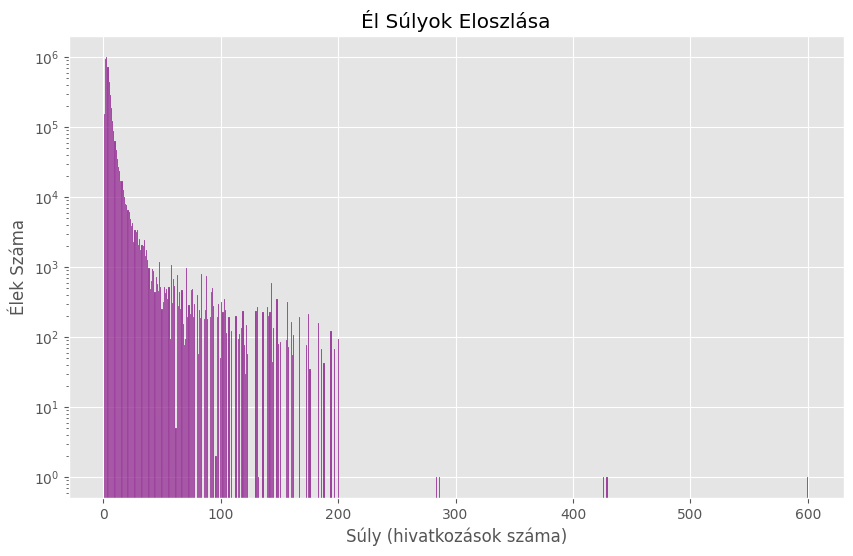

In [6]:
if G and G.number_of_edges() > 0:
    edge_relation_types = nx.get_edge_attributes(G, 'relation_type')
    
    if edge_relation_types:
        relation_type_counts = pd.Series(edge_relation_types).value_counts()
        
        print("--- Él típusok eloszlása ---")
        print(relation_type_counts)
        
        # Vizualizáció
        fig = px.bar(
            relation_type_counts,
            x=relation_type_counts.index,
            y=relation_type_counts.values,
            title="Él Típusok Gyakorisága",
            labels={'x': 'Kapcsolat Típusa', 'y': 'Élek Száma'},
            text_auto=True
        )
        fig.show()

        # Él súlyok elemzése
        edge_weights = nx.get_edge_attributes(G, 'weight')
        if edge_weights:
            weights = list(edge_weights.values())
            weight_series = pd.Series(weights)
            
            print("\n--- Él súlyok statisztikái ---")
            print(weight_series.describe())
            
            plt.figure(figsize=(10, 6))
            sns.histplot(weights, bins=max(weights), discrete=True, color='purple')
            plt.title('Él Súlyok Eloszlása')
            plt.xlabel('Súly (hivatkozások száma)')
            plt.ylabel('Élek Száma')
            plt.yscale('log')
            plt.show()
        else:
            print("\nNincsenek 'weight' attribútumok az éleken.")
    else:
        print("Nincsenek 'relation_type' attribútumok az éleken.")
else:
    print('A gráf (G) nincs betöltve vagy üres.')

## Komponens Analízis

Mivel a gráfunk irányított, megvizsgáljuk a gyengén és erősen összefüggő komponenseket.
- A **gyengén összefüggő komponensek** (WCC) azok a részgráfok, ahol bármely két csomópont között létezik útvonal, ha az élek irányát figyelmen kívül hagyjuk.
- Az **erősen összefüggő komponensek** (SCC) azok a részgráfok, ahol bármely két csomópont között létezik oda-vissza irányított útvonal.

--- Gyengén Összefüggő Komponensek (WCC) ---
Komponensek száma: 283
Legnagyobb komponens mérete: 1600619 csomópont
A csomópontok 99.98%-a a legnagyobb komponensben van.

--- Erősen Összefüggő Komponensek (SCC) ---
Komponensek száma: 1600901
Legnagyobb komponens mérete: 1 csomópont
A csomópontok 0.00%-a a legnagyobb komponensben van.


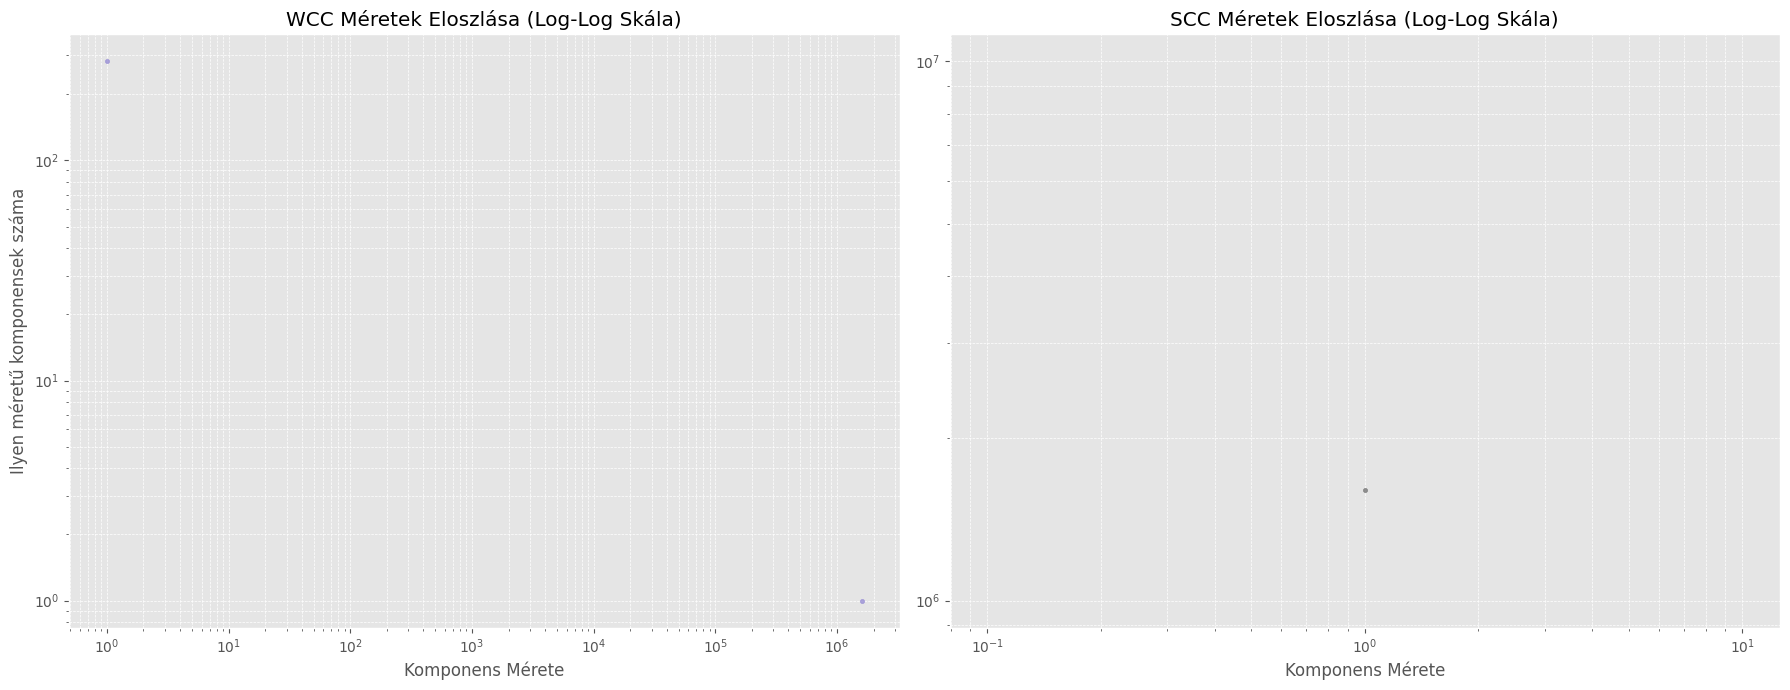

In [13]:
if G and G.number_of_nodes() > 0:
    # --- Gyengén összefüggő komponensek (WCC) ---
    wcc_generator = nx.weakly_connected_components(G)
    wcc_sizes = [len(c) for c in wcc_generator]
    # Méretek szerint csoportosítjuk és számoljuk őket
    wcc_counts = pd.Series(wcc_sizes).value_counts().sort_index()
    
    print(f"--- Gyengén Összefüggő Komponensek (WCC) ---")
    print(f"Komponensek száma: {len(wcc_sizes)}")
    if wcc_sizes:
        print(f"Legnagyobb komponens mérete: {max(wcc_sizes)} csomópont")
        print(f"A csomópontok {max(wcc_sizes) / G.number_of_nodes():.2%}-a a legnagyobb komponensben van.")
    
    # --- Erősen összefüggő komponensek (SCC) ---
    scc_generator = nx.strongly_connected_components(G)
    scc_sizes = [len(c) for c in scc_generator]
    # Méretek szerint csoportosítjuk és számoljuk őket
    scc_counts = pd.Series(scc_sizes).value_counts().sort_index()
    
    print(f"\n--- Erősen Összefüggő Komponensek (SCC) ---")
    print(f"Komponensek száma: {len(scc_sizes)}")
    if scc_sizes:
        print(f"Legnagyobb komponens mérete: {max(scc_sizes)} csomópont")
        print(f"A csomópontok {max(scc_sizes) / G.number_of_nodes():.2%}-a a legnagyobb komponensben van.")

    # --- Javított vizualizáció pontdiagrammal ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # WCC méreteloszlás
    axes[0].scatter(wcc_counts.index, wcc_counts.values, marker='.', alpha=0.8, color='C2')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_title('WCC Méretek Eloszlása (Log-Log Skála)')
    axes[0].set_xlabel('Komponens Mérete')
    axes[0].set_ylabel('Ilyen méretű komponensek száma')
    axes[0].grid(True, which="both", ls="--", linewidth=0.5)

    # SCC méreteloszlás
    axes[1].scatter(scc_counts.index, scc_counts.values, marker='.', alpha=0.8, color='C3')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_title('SCC Méretek Eloszlása (Log-Log Skála)')
    axes[1].set_xlabel('Komponens Mérete')
    axes[1].grid(True, which="both", ls="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

else:
    print('A gráf (G) nincs betöltve vagy üres.')

## Közösségdetektálás Louvain Módszerrel

A Louvain algoritmus segítségével feltárjuk a gráfban rejlő közösségeket. Ez a módszer a modularitás maximalizálásán alapul, és jól működik nagy hálózatokon is. A közösségek olyan csomópontcsoportok, amelyek sűrűbben kapcsolódnak egymáshoz, mint a csoporton kívüli csomópontokhoz. Az elemzéshez a gráf irányítatlan változatát használjuk.

Közösségdetektálás Louvain módszerrel...
Irányítatlan gráf létrehozva. Kezdődik a partícionálás...
Louvain közösségdetektálás futásideje: 511.17 másodperc

Detektált közösségek száma: 2369
Modularitás: 0.6822 (jó érték > 0.3)

--- Közösségméretek statisztikái ---
count      2369.000000
mean        675.770789
std        8765.546622
min           1.000000
25%           7.000000
50%          18.000000
75%          44.000000
max      260868.000000
Name: count, dtype: float64


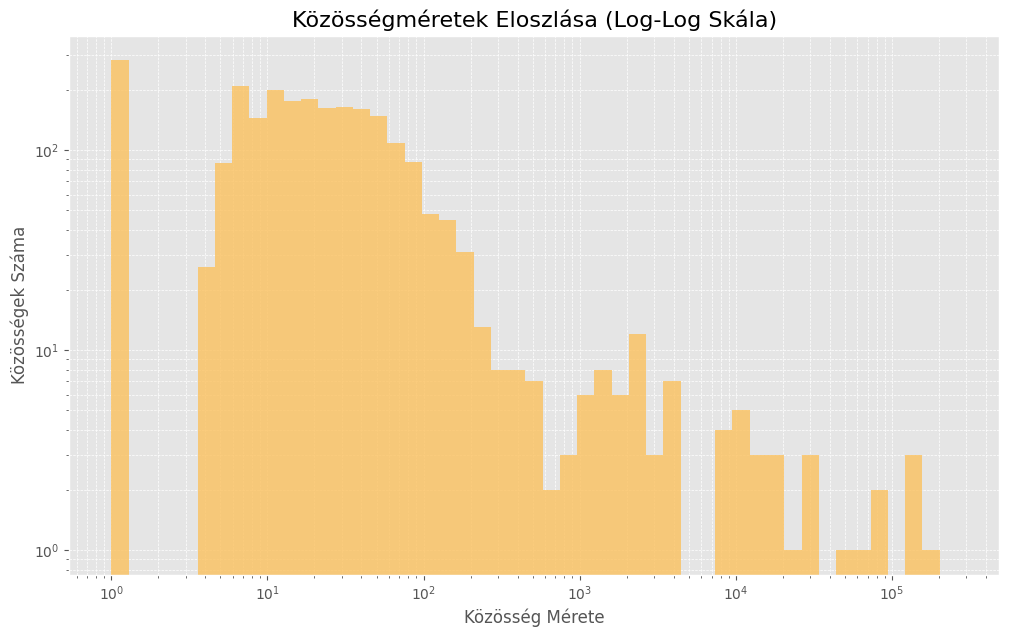

In [12]:
if G and G.number_of_nodes() > 0:
    print("Közösségdetektálás Louvain módszerrel...")
    
    # A közösségdetektáláshoz irányítatlan gráf kell
    UG = G.to_undirected()
    
    print("Irányítatlan gráf létrehozva. Kezdődik a partícionálás...")
    start_time = time.time()
    partition = community_louvain.best_partition(UG, random_state=42)
    end_time = time.time()
    
    print(f"Louvain közösségdetektálás futásideje: {end_time - start_time:.2f} másodperc")
    
    # Eredmények feldolgozása
    num_communities = len(set(partition.values()))
    modularity = community_louvain.modularity(partition, UG)
    
    print(f"\nDetektált közösségek száma: {num_communities}")
    print(f"Modularitás: {modularity:.4f} (jó érték > 0.3)")
    
    community_sizes = pd.Series(partition).value_counts()
    
    print("\n--- Közösségméretek statisztikái ---")
    print(community_sizes.describe())
    
    # Javított vizualizáció hisztogrammal és logaritmikus bin-ekkel
    plt.figure(figsize=(12, 7))
    
    sizes_to_plot = community_sizes[community_sizes > 0]

    if not sizes_to_plot.empty:
        # Logaritmikus bin-ek létrehozása a jobb vizualizációhoz
        min_size, max_size = sizes_to_plot.min(), sizes_to_plot.max()
        bins = np.logspace(np.log10(min_size), np.log10(max_size), 50)
        
        plt.hist(sizes_to_plot, bins=bins, alpha=0.8, color='C4')
        
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Közösségméretek Eloszlása (Log-Log Skála)', fontsize=16)
        plt.xlabel('Közösség Mérete', fontsize=12)
        plt.ylabel('Közösségek Száma', fontsize=12)
        plt.grid(True, which="both", ls="--", linewidth=0.5)
        plt.show()
    else:
        print("Nincsenek ábrázolható méretű közösségek.")
else:
    print('A gráf (G) nincs betöltve vagy üres.')

## Hálózat Robusztusságának Vizsgálata

A hálózat robusztussága azt méri, hogy a hálózat mennyire képes megőrizni alapvető szerkezeti tulajdonságait (pl. az összefüggőségét), miközben csomópontokat vagy éleket távolítunk el belőle. Ez a jogi hálózat kontextusában azt modellezi, hogy a rendszer mennyire "sérülékeny", ha a legfontosabb, központi csomópontokat (legyen az egy sokat idézett törvény vagy egy központi bírósági döntés) eltávolítjuk.

**Két fő forgatókönyvet vizsgálunk:**
1.  **Véletlenszerű hiba (Random Failure):** Véletlenszerűen távolítunk el csomópontokat. Ez a hálózat véletlenszerű meghibásodásokkal szembeni ellenállását méri.
2.  **Célzott támadás (Targeted Attack):** A legfontosabb csomópontokat távolítjuk el először. Két stratégia szerint célozunk:
    *   **Fokszám alapján:** A legtöbb kapcsolattal rendelkező csomópontokat vesszük ki.
    *   **Centralitás alapján:** A legmagasabb "betweenness" centralitású csomópontokat távolítjuk el. Ezek azok a csomópontok, amelyek a legtöbb legrövidebb úton fekszenek más csomópontok között, így "hídként" funkcionálnak a hálózat különböző részei között.

A vizsgálatot a gráf legnagyobb összefüggő komponensének egy mintáján végezzük el a számítási idő csökkentése érdekében.

Gráf robusztusságának elemzése...
A legnagyobb összefüggő komponens keresése...
A legnagyobb komponens mérete: 1600619 csomópont, 4290100 él.
A komponens túl nagy, mintavételezés 5000 csomópontra...
A minta legnagyobb összefüggő komponensét használjuk.
Létrehozott minta mérete: 4 csomópont, 3 él.
Betweenness centralitás számítása (eltarthat egy ideig)...
Centralitás számítása kész.
Szimuláció futtatása: 'Véletlen' stratégia...


Véletlen:   0%|          | 0/11 [00:00<?, ?it/s]

Szimuláció futtatása: 'Fokszám szerint' stratégia...


Fokszám szerint:   0%|          | 0/11 [00:00<?, ?it/s]

Szimuláció futtatása: 'Centralitás szerint' stratégia...


Centralitás szerint:   0%|          | 0/11 [00:00<?, ?it/s]

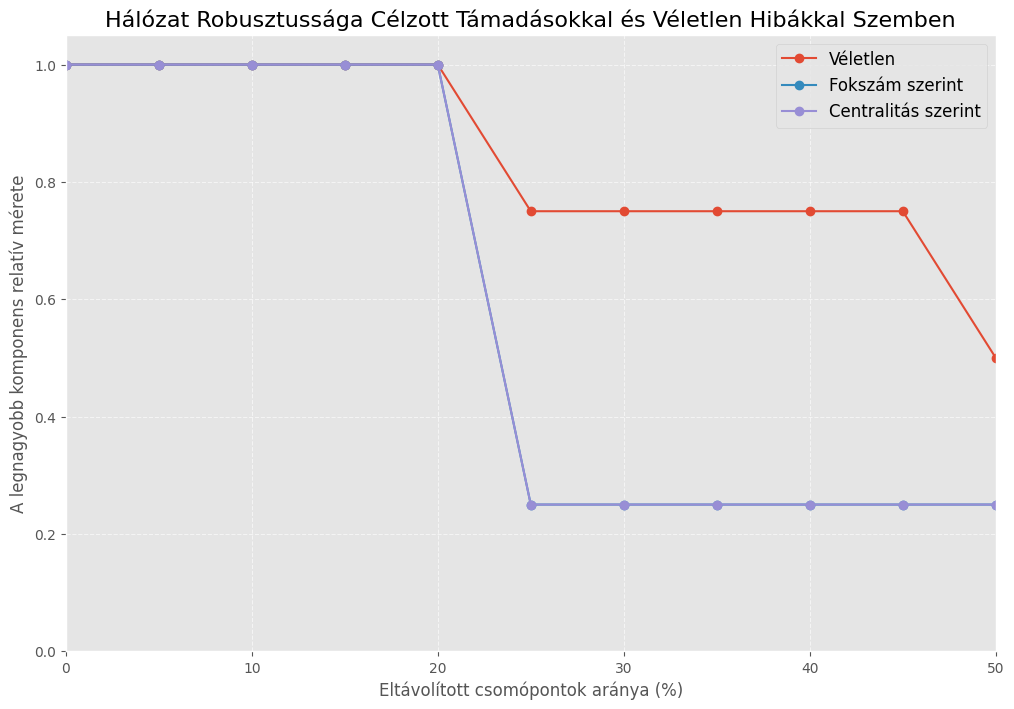

In [9]:
if 'UG' in locals() and UG and UG.number_of_nodes() > 0:
    print("Gráf robusztusságának elemzése...")

    # 1. A legnagyobb összefüggő komponenst használjuk, mivel azon van értelme a robusztusságot vizsgálni
    print("A legnagyobb összefüggő komponens keresése...")
    largest_cc_nodes = max(nx.connected_components(UG), key=len)
    G_robust_base = UG.subgraph(largest_cc_nodes).copy()
    print(f"A legnagyobb komponens mérete: {G_robust_base.number_of_nodes()} csomópont, {G_robust_base.number_of_edges()} él.")

    # 2. Ha a komponens még mindig túl nagy, mintát veszünk belőle a számításigényes centralitás miatt
    sample_size = 5000
    if G_robust_base.number_of_nodes() > sample_size:
        print(f"A komponens túl nagy, mintavételezés {sample_size} csomópontra...")
        sample_nodes = np.random.choice(list(G_robust_base.nodes()), sample_size, replace=False)
        G_robust = G_robust_base.subgraph(sample_nodes).copy()
        
        # Biztosítjuk, hogy a mintavételezett gráf is összefüggő legyen
        if not nx.is_connected(G_robust):
            largest_cc_sample_nodes = max(nx.connected_components(G_robust), key=len)
            G_robust = G_robust.subgraph(largest_cc_sample_nodes).copy()
            print("A minta legnagyobb összefüggő komponensét használjuk.")
        
        print(f"Létrehozott minta mérete: {G_robust.number_of_nodes()} csomópont, {G_robust.number_of_edges()} él.")
    else:
        G_robust = G_robust_base

    # 3. Csomópontok sorbarendezése a támadási stratégiákhoz
    n_nodes = G_robust.number_of_nodes()
    
    # Stratégia 1: Véletlen sorrend
    nodes_random = list(G_robust.nodes())
    np.random.shuffle(nodes_random)
    
    # Stratégia 2: Fokszám szerinti sorrend
    nodes_by_degree = sorted(G_robust.degree(), key=lambda x: x[1], reverse=True)
    nodes_by_degree = [n for n, d in nodes_by_degree]
    
    # Stratégia 3: Betweenness centralitás szerinti sorrend (közelítéssel a gyorsaságért)
    print("Betweenness centralitás számítása (eltarthat egy ideig)...")
    k_for_betweenness = min(n_nodes, 200) # Minta a centralitás becsléséhez
    betweenness = nx.betweenness_centrality(G_robust, k=k_for_betweenness, seed=42)
    nodes_by_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    nodes_by_betweenness = [n for n, c in nodes_by_betweenness]
    print("Centralitás számítása kész.")

    # 4. A szimuláció futtatása
    removal_steps = np.linspace(0, 0.5, 11) # A csomópontok 0-50%-át távolítjuk el
    results = defaultdict(list)
    
    for strategy_name, node_order in [("Véletlen", nodes_random), 
                                      ("Fokszám szerint", nodes_by_degree), 
                                      ("Centralitás szerint", nodes_by_betweenness)]:
        print(f"Szimuláció futtatása: '{strategy_name}' stratégia...")
        for fraction in tqdm(removal_steps, desc=strategy_name):
            nodes_to_remove = node_order[:int(n_nodes * fraction)]
            
            # Gráf másolása és csomópontok eltávolítása
            temp_G = G_robust.copy()
            temp_G.remove_nodes_from(nodes_to_remove)
            
            if temp_G.number_of_nodes() > 0:
                # A legnagyobb komponens relatív méretének mérése
                largest_cc = max(nx.connected_components(temp_G), key=len)
                lcc_size_fraction = len(largest_cc) / n_nodes
                results[strategy_name].append(lcc_size_fraction)
            else:
                results[strategy_name].append(0)

    # 5. Eredmények vizualizálása
    plt.figure(figsize=(12, 8))
    
    for strategy_name, lcc_sizes in results.items():
        plt.plot(removal_steps * 100, lcc_sizes, 'o-', label=strategy_name)
        
    plt.title('Hálózat Robusztussága Célzott Támadásokkal és Véletlen Hibákkal Szemben', fontsize=16)
    plt.xlabel('Eltávolított csomópontok aránya (%)', fontsize=12)
    plt.ylabel('A legnagyobb komponens relatív mérete', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.ylim(0, 1.05)
    plt.xlim(0, max(removal_steps)*100)
    plt.show()

else:
    print('A gráf (UG) nincs betöltve vagy üres. Futtasd a közösségdetektálási cellát!')